In [4]:
import pandas as pd
import numpy as np
import os


In [7]:
os.listdir()

['.ipynb_checkpoints', 'api_validation.ipynb', 'eda.ipynb']

In [8]:
os.chdir("D:\\umyma\\Internship 10Pearls\\AQI_Predictor")

In [9]:
os.getcwd()

'D:\\umyma\\Internship 10Pearls\\AQI_Predictor'

In [11]:
os.listdir()

['.git',
 '.github',
 'app',
 'data',
 'LICENSE',
 'models',
 'notebooks',
 'README.md',
 'requirements.txt',
 'src',
 'test.csv']

In [16]:
merged_df=pd.read_parquet("data\\raw\\merged_data_bwp.parquet")
merged_df.head()
merged_df.tail()
merged_df.shape

(1416, 15)

In [19]:
#checking sum of missing values for each column 
merged_df.isna().sum()
#no missing values for any column

timestamp               0
temperature_2m          0
relative_humidity_2m    0
wind_speed_10m          0
pressure_msl            0
wind_direction_10m      0
precipitation           0
cloud_cover_low         0
pm10                    0
pm2_5                   0
carbon_monoxide         0
nitrogen_dioxide        0
sulphur_dioxide         0
ozone                   0
carbon_dioxide          0
dtype: int64

In [33]:
#checking for duplicate timestamps
merged_df["timestamp"].duplicated().sum()
#no duplicate timestamps


0

In [34]:
# i will be creating 3 types of derived features : 
#a) time based features (hr,dayOfWeek, day,month) 
#b) lag features (lag 1, 6 and 24)
#c) rolling features (6a nd 24) + pm25_change_1hr 

# TIME BASED FEATURES
merged_df["hour"]=merged_df["timestamp"].dt.hour
merged_df["day_of_week"]=merged_df["timestamp"].dt.dayofweek
merged_df["day"]=merged_df["timestamp"].dt.day
merged_df["month"]=merged_df["timestamp"].dt.month

In [37]:
merged_df.head()

,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,wind_direction_10m,precipitation,cloud_cover_low,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,carbon_dioxide,new_column,hour,day_of_week,day,month
0,2025-11-05 00:00:00+00:00,18.40,69.179977,8.936778,1010.599976,9.272532,0.0,0.0,68.199997,64.699997,636.0,18.700001,6.9,35.0,454.0,0,0,2,5,11
1,2025-11-05 01:00:00+00:00,17.85,72.555122,9.761578,1011.299988,354.709991,0.0,0.0,70.500000,69.199997,709.0,17.500000,7.4,37.0,454.0,0,1,2,5,11
2,2025-11-05 02:00:00+00:00,17.65,74.685219,10.837435,1012.200012,11.496537,0.0,0.0,75.199997,73.300003,816.0,15.800000,8.2,40.0,455.0,0,2,2,5,11
3,2025-11-05 03:00:00+00:00,19.25,69.346954,10.308830,1012.799988,24.775122,0.0,0.0,76.400002,74.500000,859.0,13.600000,9.1,50.0,455.0,0,3,2,5,11
4,2025-11-05 04:00:00+00:00,21.90,60.446892,8.155807,1013.599976,22.036283,0.0,0.0,76.400002,72.599998,783.0,10.600000,10.4,74.0,454.0,0,4,2,5,11


In [39]:
# LAG FEATURES
merged_df["pm25_lag1"]=merged_df["pm2_5"].shift(1)
merged_df["pm25_lag6"]=merged_df["pm2_5"].shift(6)
merged_df["pm25_lag24"]=merged_df["pm2_5"].shift(24)

In [41]:
merged_df.head()
merged_df.tail()

,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,wind_direction_10m,precipitation,cloud_cover_low,pm10,pm2_5,...,ozone,carbon_dioxide,new_column,hour,day_of_week,day,month,pm25_lag1,pm25_lag6,pm25_lag24
1411,2026-01-02 19:00:00+00:00,10.05,93.506500,4.669604,1019.299988,152.447281,0.0,0.0,134.600006,131.800003,...,41.0,492.0,0,19,4,2,1,152.699997,109.400002,143.000000
1412,2026-01-02 20:00:00+00:00,9.75,93.491562,4.471107,1019.000000,139.899155,0.0,0.0,113.900002,111.099998,...,48.0,492.0,0,20,4,2,1,131.800003,131.800003,150.899994
1413,2026-01-02 21:00:00+00:00,9.45,93.476570,4.427414,1018.700012,153.435013,0.0,0.0,98.699997,95.699997,...,54.0,492.0,0,21,4,2,1,111.099998,149.500000,160.699997
1414,2026-01-02 22:00:00+00:00,9.10,94.736145,4.978554,1018.599976,167.471207,0.0,0.0,88.199997,85.199997,...,57.0,492.0,0,22,4,2,1,95.699997,159.699997,168.600006
1415,2026-01-02 23:00:00+00:00,8.90,95.697380,5.269422,1018.099976,172.146774,0.0,0.0,82.400002,79.400002,...,60.0,492.0,0,23,4,2,1,85.199997,161.100006,172.300003


In [42]:
# ROLLING FEATURES

merged_df["pm25_ma6"]=merged_df["pm2_5"].rolling(6).mean()
merged_df["pm25_ma24"]=merged_df["pm2_5"].rolling(24).mean()
merged_df["pm25_change_1hr"]=merged_df["pm2_5"]-merged_df["pm25_lag1"]

In [43]:
merged_df.head()

,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,wind_direction_10m,precipitation,cloud_cover_low,pm10,pm2_5,...,hour,day_of_week,day,month,pm25_lag1,pm25_lag6,pm25_lag24,pm25_ma6,pm25_ma24,pm25_change_1hr
0,2025-11-05 00:00:00+00:00,18.40,69.179977,8.936778,1010.599976,9.272532,0.0,0.0,68.199997,64.699997,...,0,2,5,11,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-11-05 01:00:00+00:00,17.85,72.555122,9.761578,1011.299988,354.709991,0.0,0.0,70.500000,69.199997,...,1,2,5,11,64.699997,NaN,NaN,NaN,NaN,4.500000
2,2025-11-05 02:00:00+00:00,17.65,74.685219,10.837435,1012.200012,11.496537,0.0,0.0,75.199997,73.300003,...,2,2,5,11,69.199997,NaN,NaN,NaN,NaN,4.100006
3,2025-11-05 03:00:00+00:00,19.25,69.346954,10.308830,1012.799988,24.775122,0.0,0.0,76.400002,74.500000,...,3,2,5,11,73.300003,NaN,NaN,NaN,NaN,1.199997
4,2025-11-05 04:00:00+00:00,21.90,60.446892,8.155807,1013.599976,22.036283,0.0,0.0,76.400002,72.599998,...,4,2,5,11,74.500000,NaN,NaN,NaN,NaN,-1.900002


In [44]:
# droppping all rows containing NaNs
merged_df=merged_df.dropna()

In [46]:
merged_df.head()
merged_df.columns

Index(['timestamp', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
       'pressure_msl', 'wind_direction_10m', 'precipitation',
       'cloud_cover_low', 'pm10', 'pm2_5', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'carbon_dioxide',
       'new_column', 'hour', 'day_of_week', 'day', 'month', 'pm25_lag1',
       'pm25_lag6', 'pm25_lag24', 'pm25_ma6', 'pm25_ma24', 'pm25_change_1hr'],
      dtype='object')

In [52]:
merged_df.columns

Index(['timestamp', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
       'pressure_msl', 'wind_direction_10m', 'precipitation',
       'cloud_cover_low', 'pm10', 'pm2_5', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'carbon_dioxide',
       'new_column', 'hour', 'day_of_week', 'day', 'month', 'pm25_lag1',
       'pm25_lag6', 'pm25_lag24', 'pm25_ma6', 'pm25_ma24', 'pm25_change_1hr'],
      dtype='object')

In [53]:
if 'new_column' in merged_df.columns:
    merged_df = merged_df.drop(columns=['new_column'])

                     timestamp  temperature_2m  relative_humidity_2m  \
24   2025-11-06 00:00:00+00:00       16.250000             50.315456   
25   2025-11-06 01:00:00+00:00       15.800000             51.424698   
26   2025-11-06 02:00:00+00:00       15.750000             52.669910   
27   2025-11-06 03:00:00+00:00       18.049999             47.606617   
28   2025-11-06 04:00:00+00:00       21.200001             41.211811   
...                        ...             ...                   ...   
1411 2026-01-02 19:00:00+00:00       10.050000             93.506500   
1412 2026-01-02 20:00:00+00:00        9.750000             93.491562   
1413 2026-01-02 21:00:00+00:00        9.450000             93.476570   
1414 2026-01-02 22:00:00+00:00        9.100000             94.736145   
1415 2026-01-02 23:00:00+00:00        8.900000             95.697380   

      wind_speed_10m  pressure_msl  wind_direction_10m  precipitation  \
24          8.619349   1013.099976          118.705856        

In [55]:
merged_df.columns

Index(['timestamp', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
       'pressure_msl', 'wind_direction_10m', 'precipitation',
       'cloud_cover_low', 'pm10', 'pm2_5', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'carbon_dioxide',
       'hour', 'day_of_week', 'day', 'month', 'pm25_lag1', 'pm25_lag6',
       'pm25_lag24', 'pm25_ma6', 'pm25_ma24', 'pm25_change_1hr'],
      dtype='object')

In [56]:
 # CORRELATION HEATMAP

import seaborn as sns
import matplotlib.pyplot as plt

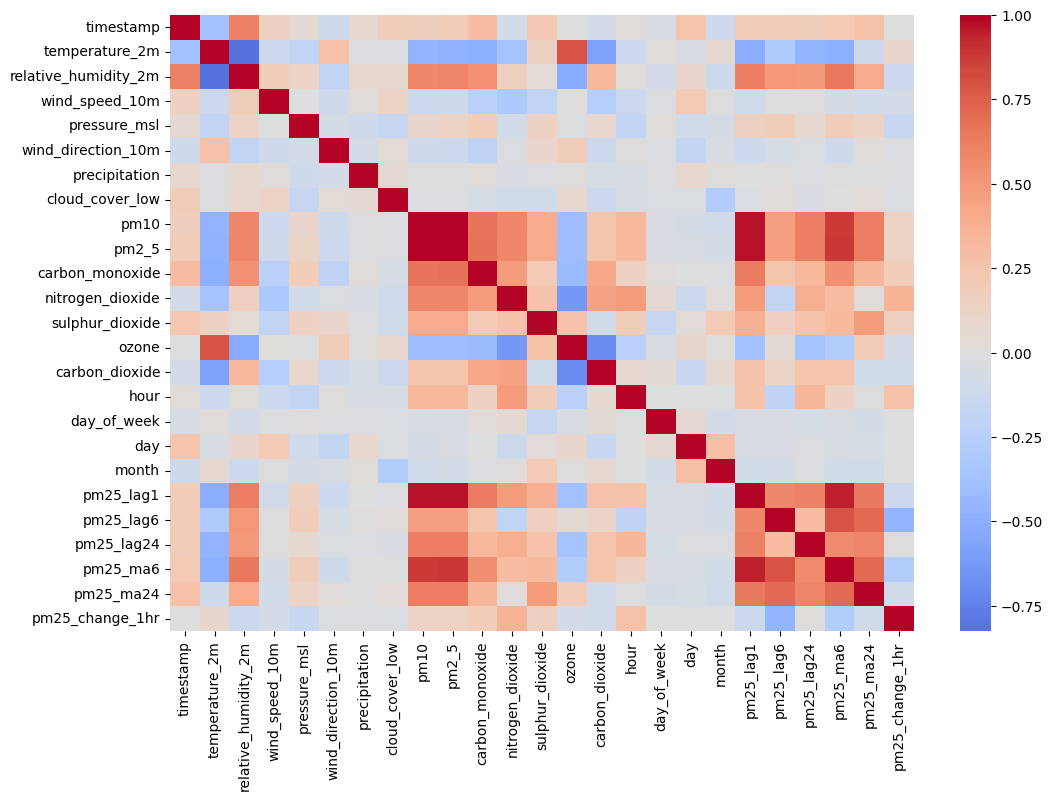

In [57]:
plt.figure(figsize=(12,8))
sns.heatmap(
    merged_df.corr(),
    cmap="coolwarm",
    center=0
)
plt.show()

<Axes: xlabel='wind_speed_10m', ylabel='pm2_5'>

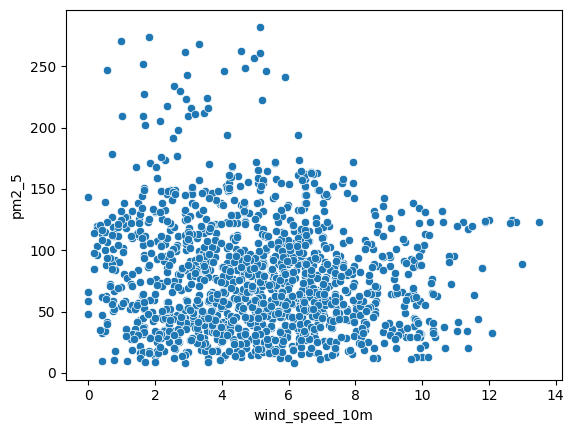

In [59]:
sns.scatterplot(x="wind_speed_10m", y="pm2_5", data=merged_df)

<Axes: xlabel='pressure_msl', ylabel='pm2_5'>

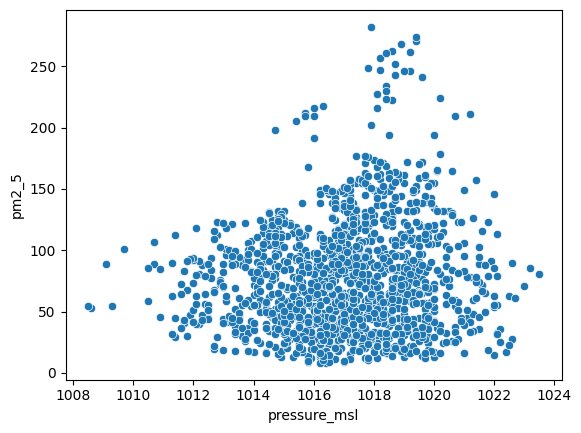

In [60]:
sns.scatterplot(x="pressure_msl", y="pm2_5", data=merged_df)

<Axes: xlabel='relative_humidity_2m', ylabel='pm2_5'>

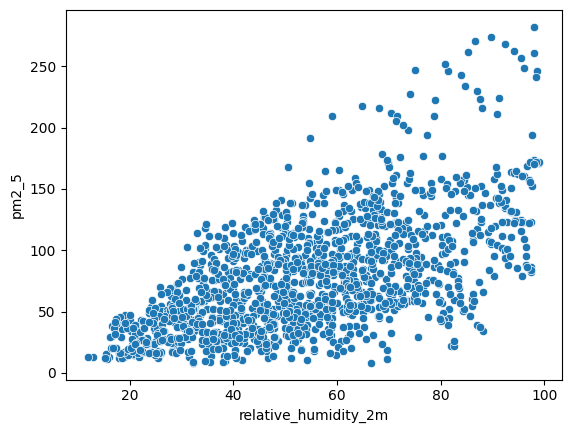

In [62]:
 sns.scatterplot(x="relative_humidity_2m", y="pm2_5", data=merged_df)

<Axes: xlabel='wind_direction_10m', ylabel='pm2_5'>

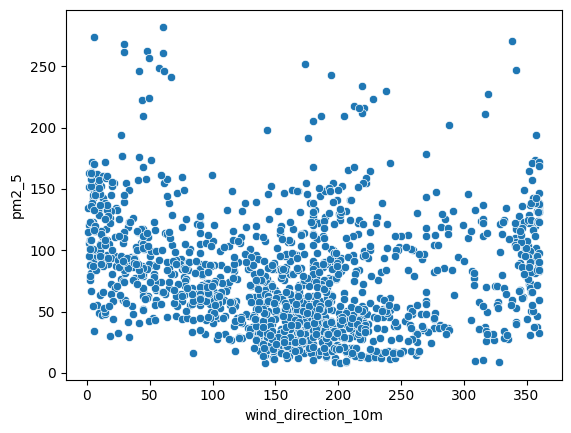

In [63]:
 sns.scatterplot(x="wind_direction_10m", y="pm2_5", data=merged_df)

<Axes: xlabel='ozone', ylabel='pm2_5'>

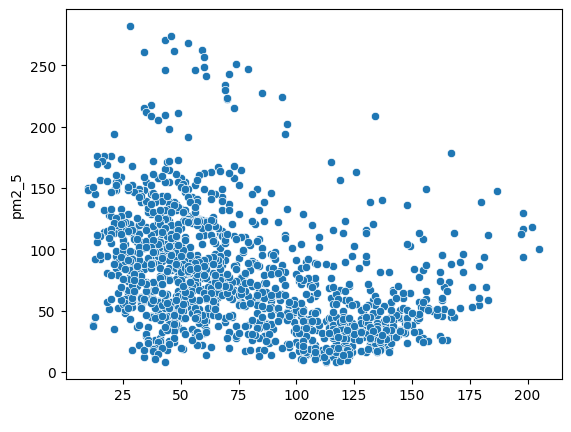

In [65]:
 sns.scatterplot(x="ozone", y="pm2_5", data=merged_df)